<a href="https://colab.research.google.com/github/Thanveerahmd/Fyp_Violence_transformer/blob/main/10_FPS_VSD_video_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Mon Oct 11 07:00:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
cd /content/gdrive/MyDrive/Final_Year_Project/Dataset/10fps_VSD

/content/gdrive/MyDrive/Final_Year_Project/Dataset/10fps_VSD


In [7]:
ls

10fps_violent/                     10fps_violent_VSD_train.csv
10fps_violent_VSD/                 10fps_violent_VSD_train_data.npy
10fps_violent_VSD_test.csv         10fps_violent_VSD_train_labels.npy
10fps_violent_VSD_test_data.npy    10fps_violent_VSD_train.txt
10fps_violent_VSD_test_labels.npy  10fps_VSD.tar.gz
10fps_violent_VSD_test.txt


In [8]:
!pip install -q git+https://github.com/tensorflow/docs

## Setup

In [9]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [47]:
MAX_SEQ_LENGTH = 50
NUM_FEATURES = 1024
IMG_SIZE = 224

EPOCHS = 50

## Data preparation

We will mostly be following the same data preparation steps in this example, except for
the following changes:

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

First, let's load up the
[DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [11]:
train_df = pd.read_csv("10fps_violent_VSD_train.csv")
test_df = pd.read_csv("10fps_violent_VSD_test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 2913
Total videos for testing: 734


In [57]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


number of frame in video : 81.0
frame shape: (81, 224, 224, 3)


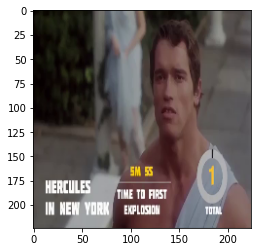

In [ ]:
video_file = '/content/gdrive/MyDrive/Final_Year_Project/Dataset/10fps_VSD/10fps_violent_VSD/train/explosions/OVERKILL - The Schwarzenegger Explosion Supercut - 007-8.mp4'

cap = cv2.VideoCapture(video_file)
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

print(f'number of frame in video : {totalFrames}')

frames = []
while True:
    has_frame, image = cap.read()
    
    if has_frame:
        #image = crop_center_square(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image[:, :, ::-1] # convert BGR -> RGB
        frames.append(image)
    else:
        break
frames = np.stack(frames, axis=0)

print(f'frame shape: {frames.shape}')    
plt.imshow(frames[0])

In [58]:
def load_video(path, max_frames=0):

    cap = cv2.VideoCapture(path)

    width  = cap.get(3)  # float `width`
    height = cap.get(4)  # float `height`
    print('width, height:', width, height)

    frames = []
    try:
        while True:

            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center(frame)
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)/255

In [59]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

29097984/29084464 [==============================] - 0s 0us/step


In [12]:
# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())

['Sport fights', 'Torturing and bulling', 'Violence fights', 'blood and gore', 'carchase', 'coldarms', 'explosions', 'firearms', 'nonViolent']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        #print(path)
        print(frames.shape)
        print(idx)

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate((frames, padding))

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


In [ ]:
train_data, train_labels = prepare_all_videos(train_df, "10fps_violent_VSD/train")
test_data, test_labels = prepare_all_videos(test_df, "10fps_violent_VSD/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

In [ ]:
from numpy import save

save('10fps_violent_VSD_train_data.npy', train_data)
save('10fps_violent_VSD_train_labels.npy', train_labels)
save('10fps_violent_VSD_test_data.npy', test_data)
save('10fps_violent_VSD_test_labels.npy', test_labels)

In [13]:
ls

10fps_violent/                     10fps_violent_VSD_train.csv
10fps_violent_VSD/                 10fps_violent_VSD_train_data.npy
10fps_violent_VSD_test.csv         10fps_violent_VSD_train_labels.npy
10fps_violent_VSD_test_data.npy    10fps_violent_VSD_train.txt
10fps_violent_VSD_test_labels.npy  10fps_VSD.tar.gz
10fps_violent_VSD_test.txt


In [14]:
train_data, train_labels = np.load("10fps_violent_VSD_train_data.npy"), np.load("10fps_violent_VSD_train_labels.npy")
test_data, test_labels = np.load("10fps_violent_VSD_test_data.npy"), np.load("10fps_violent_VSD_test_labels.npy")

In [15]:
print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in train label set: {train_labels.shape}")
print(f"Frame features in test set: {test_data.shape}")
print(f"Frame features in test label set: {test_labels.shape}")

Frame features in train set: (2913, 50, 1024)
Frame features in train label set: (2913, 1)
Frame features in test set: (734, 50, 1024)
Frame features in test label set: (734, 1)


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

## Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [16]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask


Now, we can create a subclassed layer for the Transformer.

In [17]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


In [48]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(embed_dim,return_sequences=True))(x)
    x = TransformerEncoder(2*embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [49]:
model = get_compiled_model()

In [50]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None)]      0         
_________________________________________________________________
frame_position_embedding (Po (None, None, 1024)        51200     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 2048)        16785408  
_________________________________________________________________
transformer_layer (Transform (None, None, 2048)        16812036  
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 1844

## Utility functions for training

In [51]:
def run_experiment():
    # filepath = "/tmp/video_classifier"
    # checkpoint = keras.callbacks.ModelCheckpoint(
    #     filepath, save_weights_only=True, save_best_only=True, verbose=1
    # )

    
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
       # callbacks=[checkpoint],
    )

    #model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model,history


## Model training and inference

In [52]:
trained_model,history = run_experiment()

Epoch 1/50
78/78 [==============================] - 38s 361ms/step - loss: 4.0100 - accuracy: 0.1361 - val_loss: 8.9271 - val_accuracy: 0.0000e+00
Epoch 2/50
78/78 [==============================] - 25s 323ms/step - loss: 2.7630 - accuracy: 0.1454 - val_loss: 10.0173 - val_accuracy: 0.0000e+00
Epoch 3/50
78/78 [==============================] - 25s 324ms/step - loss: 2.5788 - accuracy: 0.1878 - val_loss: 10.9140 - val_accuracy: 0.0000e+00
Epoch 4/50
78/78 [==============================] - 25s 327ms/step - loss: 1.5436 - accuracy: 0.4592 - val_loss: 11.5624 - val_accuracy: 0.0000e+00
Epoch 5/50
78/78 [==============================] - 25s 321ms/step - loss: 1.0487 - accuracy: 0.6486 - val_loss: 10.9566 - val_accuracy: 0.0000e+00
Epoch 6/50
78/78 [==============================] - 25s 324ms/step - loss: 0.8234 - accuracy: 0.7197 - val_loss: 10.6185 - val_accuracy: 0.0000e+00
Epoch 7/50
78/78 [==============================] - 26s 329ms/step - loss: 0.6967 - accuracy: 0.7682 - val_loss: 

In [66]:
from sklearn.metrics import classification_report

In [67]:
yhat = model.predict(test_data)
y_pred  = np.argmax(yhat, axis=1)
target_names = label_processor.get_vocabulary()
print(classification_report(test_labels, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

         Sport fights       0.77      0.85      0.81        73
Torturing and bulling       0.27      0.95      0.41        82
      Violence fights       0.00      0.00      0.00        87
       blood and gore       0.54      0.62      0.57        81
             carchase       0.71      0.86      0.77        90
             coldarms       0.00      0.00      0.00        82
           explosions       0.80      0.44      0.57        81
             firearms       1.00      0.01      0.02        87
           nonViolent       0.55      0.86      0.67        71

             accuracy                           0.50       734
            macro avg       0.51      0.51      0.43       734
         weighted avg       0.51      0.50      0.42       734



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
from matplotlib import pyplot

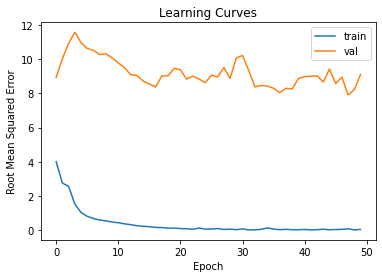

In [54]:
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Root Mean Squared Error')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()


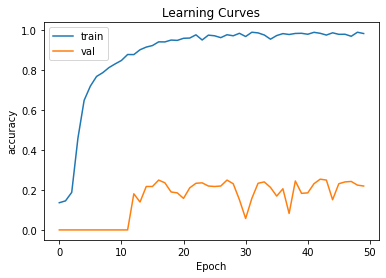

In [55]:
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='val')
    pyplot.legend()
    pyplot.show()

**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

Test video path: coldarms/videoplayback (11) - 001-216.mp4
width, height: 640.0 268.0
  blood and gore: 88.08%
  nonViolent:  7.49%
  Torturing and bulling:  3.08%
  carchase:  1.26%
  Sport fights:  0.09%
  coldarms:  0.00%
  explosions:  0.00%
  firearms:  0.00%
  Violence fights:  0.00%



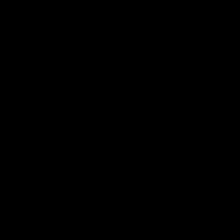

In [64]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("10fps_violent_VSD/test/", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

The performance of our model is far from optimal, because it was trained on a
small dataset.